In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyeit.mesh as mesh
import math
import cv2

In [1]:
from pyEIT_image_wrapper import *

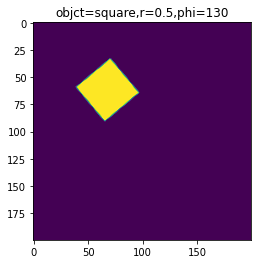

In [2]:
IMG = geometry_to_img_wrot(objct='square', r=0.5, phi=130, d=0.2)
plt.title("objct=square,r=0.5,phi=130")
plt.imshow(IMG)

1.0
10.0


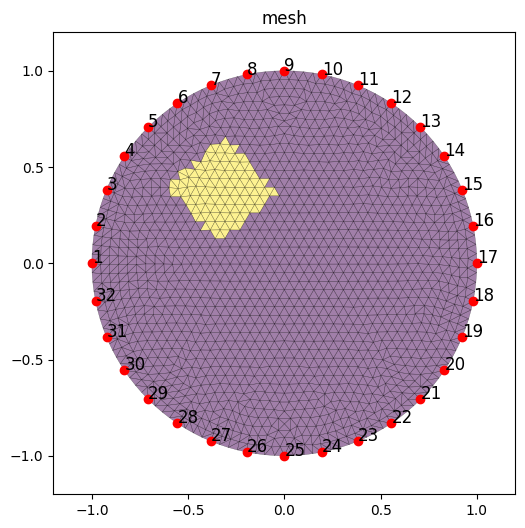

In [3]:
n_el = 32
el_pos = np.arange(n_el)
mesh_obj = groundtruth_IMG_based(IMG, n_el, perm_empty_gnd=1, perm_obj=10)
plot_mesh(mesh_obj, el_pos)
print(np.min(mesh_obj['perm']))
print(np.max(mesh_obj['perm']))

# Demo picture

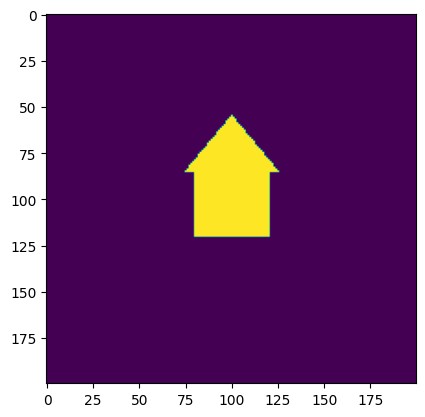

In [5]:
def pol2cart(r, phi):
    x = r * np.cos(phi)+100
    y = r * np.sin(phi)+100
    return (int(x), int(y))

d=0.2

IMG = np.zeros((200,200))
center_coordinates = pol2cart(0,0)#*0 für die Rotation
start_point = (int(center_coordinates[0]-int(d*100)), center_coordinates[1]-int(d*100))
end_point = (center_coordinates[0]+int(d*100), center_coordinates[1]+int(d*100))
color = (1, 0, 0)
thickness = -1
IMG = cv2.rectangle(IMG, start_point, end_point, color, thickness)
d=0.25
center_coordinates = pol2cart(0,0)
pt1 = (int(center_coordinates[0]), int(center_coordinates[1]-int((d)*100)-20))
pt2 = (int(center_coordinates[0]+int((d)*100)), int(center_coordinates[1])+int((d)*100)-40)
pt3 = (int(center_coordinates[0]-int((d)*100)), int(center_coordinates[1])+int((d)*100)-40)
tri_edges = np.array( [pt1, pt2, pt3] )
IMG = cv2.drawContours(IMG, [tri_edges], 0, (1,0,0), -1)
plt.imshow(IMG)
#plt.savefig("house_img.png", dpi=300)

In [9]:
n_el = 16
el_pos = np.arange(n_el)
mesh_obj = groundtruth_IMG_based(IMG, n_el, perm_empty_gnd=1, perm_obj=10)

Text(0.5, 1.0, 'Meshed house, $h_0 = 0.05$')

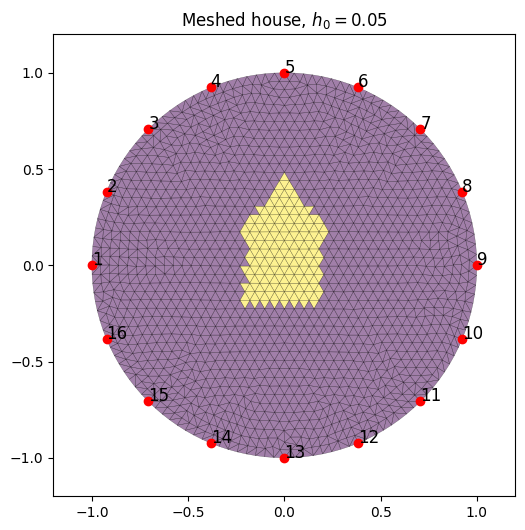

In [10]:
plot_mesh(mesh_obj, el_pos)
plt.title("Meshed house, $h_0 = 0.05$")
#plt.savefig("meshed_house_based_05.png", dpi=300)